## Import libraries

In [1]:
import gc
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers

np.random.seed(42)
tf.random.set_seed(42)
plt.style.use('fivethirtyeight')

## Load source datasets

In [2]:
train = pd.read_csv("../input/mh-analytics-olympiad-2022/AnalyticsOlympiad2022Data/train.csv")
print(f"train: {train.shape}")
train.head()

train: (105000, 18)


,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE
0,816393,40-64,female,20-29y,university,middle class,0.638050,0.0,after 2015,0.0,0.0,37379,11000.0,0,0,0,0.0,Sports Car
1,251762,26-39,male,20-29y,high school,middle class,0.475741,1.0,before 2015,1.0,0.0,10238,9000.0,0,0,0,1.0,HatchBack
2,481952,40-64,male,20-29y,none,middle class,0.839817,1.0,before 2015,1.0,1.0,10238,12000.0,0,0,0,1.0,Sedan
3,3506,40-64,male,20-29y,high school,upper class,0.682527,1.0,before 2015,0.0,1.0,92099,6000.0,1,0,0,1.0,Sedan
4,498013,40-64,female,20-29y,none,working class,0.572184,1.0,after 2015,1.0,1.0,32122,15000.0,0,0,1,0.0,Sedan


In [3]:
test = pd.read_csv("../input/mh-analytics-olympiad-2022/AnalyticsOlympiad2022Data/test.csv")
print(f"test: {test.shape}")
test.head()

test: (45000, 17)


,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,TYPE_OF_VEHICLE
0,352928,40-64,male,10-19y,none,working class,0.814707,1.0,after 2015,0.0,1.0,10238,10000.0,0,0,0,HatchBack
1,38579,26-39,female,20-29y,high school,upper class,0.344051,1.0,before 2015,0.0,0.0,34073,13000.0,0,0,0,Sedan
2,504022,40-64,male,10-19y,none,upper class,0.620691,0.0,after 2015,1.0,0.0,10238,12000.0,0,0,0,SUV
3,202404,26-39,male,20-29y,high school,upper class,0.689658,1.0,after 2015,1.0,1.0,10238,16000.0,1,0,0,SUV
4,527913,65+,male,10-19y,none,middle class,0.755666,0.0,after 2015,0.0,1.0,92101,14000.0,2,0,0,HatchBack


## Data preprocessing

In [4]:
train['US_STATE'] = train['POSTAL_CODE'].apply(
    lambda x: 
    'AL' if x>=35004 and x<=36925 else
    'AK' if x>=99501 and x<=99950 else
    'AZ' if x>=85001 and x<=86556 else
    'AR' if x>=71601 and x<=72959 else
    'CA' if x>=90001 and x<=96162 else
    'CO' if x>=80001 and x<=81658 else
    'CT' if x>=6001  and x<=6928  else
    'DE' if x>=19701 and x<=19980 else
    'FL' if x>=32003 and x<=34997 else
    'GA' if x>=30002 and x<=39901 else
    'HI' if x>=96701 and x<=96898 else
    'ID' if x>=83201 and x<=83877 else
    'IL' if x>=60001 and x<=62999 else
    'IN' if x>=46001 and x<=47997 else
    'IA' if x>=50001 and x<=52809 else
    'KS' if x>=66002 and x<=67954 else
    'KY' if x>=40003 and x<=42788 else
    'LA' if x>=70001 and x<=71497 else
    'ME' if x>=3901  and x<=4992  else
    'MD' if x>=20588 and x<=21930 else
    'MA' if x>=1001  and x<=5544  else
    'MI' if x>=48001 and x<=49971 else
    'MN' if x>=55001 and x<=56763 else
    'MS' if x>=38601 and x<=39776 else
    'MO' if x>=63001 and x<=65899 else
    'MT' if x>=59001 and x<=59937 else
    'NE' if x>=68001 and x<=69367 else
    'NV' if x>=88901 and x<=89883 else
    'NH' if x>=3031  and x<=3897  else
    'NJ' if x>=7001  and x<=8989  else
    'NM' if x>=87001 and x<=88439 else
    'NY' if x>=501   and x<=14925 else
    'NC' if x>=27006 and x<=28909 else
    'ND' if x>=58001 and x<=58856 else
    'OH' if x>=43001 and x<=45999 else
    'OK' if x>=73001 and x<=74966 else
    'OR' if x>=97001 and x<=97920 else
    'PA' if x>=15001 and x<=19640 else
    'RI' if x>=2801  and x<=2940  else
    'SC' if x>=29001 and x<=29945 else
    'SD' if x>=57001 and x<=57799 else
    'TN' if x>=37010 and x<=38589 else
    'TX' if x>=73301 and x<=88595 else
    'UT' if x>=84001 and x<=84791 else
    'VT' if x>=5001  and x<=5907  else
    'VA' if x>=20101 and x<=24658 else
    'WA' if x>=98001 and x<=99403 else
    'WV' if x>=24701 and x<=26886 else
    'WI' if x>=53001 and x<=54990 else
    'WY' if x>=82001 and x<=83414 else
    'Not Available'
)

In [5]:
test['US_STATE'] = test['POSTAL_CODE'].apply(
    lambda x: 
    'AL' if x>=35004 and x<=36925 else
    'AK' if x>=99501 and x<=99950 else
    'AZ' if x>=85001 and x<=86556 else
    'AR' if x>=71601 and x<=72959 else
    'CA' if x>=90001 and x<=96162 else
    'CO' if x>=80001 and x<=81658 else
    'CT' if x>=6001  and x<=6928  else
    'DE' if x>=19701 and x<=19980 else
    'FL' if x>=32003 and x<=34997 else
    'GA' if x>=30002 and x<=39901 else
    'HI' if x>=96701 and x<=96898 else
    'ID' if x>=83201 and x<=83877 else
    'IL' if x>=60001 and x<=62999 else
    'IN' if x>=46001 and x<=47997 else
    'IA' if x>=50001 and x<=52809 else
    'KS' if x>=66002 and x<=67954 else
    'KY' if x>=40003 and x<=42788 else
    'LA' if x>=70001 and x<=71497 else
    'ME' if x>=3901  and x<=4992  else
    'MD' if x>=20588 and x<=21930 else
    'MA' if x>=1001  and x<=5544  else
    'MI' if x>=48001 and x<=49971 else
    'MN' if x>=55001 and x<=56763 else
    'MS' if x>=38601 and x<=39776 else
    'MO' if x>=63001 and x<=65899 else
    'MT' if x>=59001 and x<=59937 else
    'NE' if x>=68001 and x<=69367 else
    'NV' if x>=88901 and x<=89883 else
    'NH' if x>=3031  and x<=3897  else
    'NJ' if x>=7001  and x<=8989  else
    'NM' if x>=87001 and x<=88439 else
    'NY' if x>=501   and x<=14925 else
    'NC' if x>=27006 and x<=28909 else
    'ND' if x>=58001 and x<=58856 else
    'OH' if x>=43001 and x<=45999 else
    'OK' if x>=73001 and x<=74966 else
    'OR' if x>=97001 and x<=97920 else
    'PA' if x>=15001 and x<=19640 else
    'RI' if x>=2801  and x<=2940  else
    'SC' if x>=29001 and x<=29945 else
    'SD' if x>=57001 and x<=57799 else
    'TN' if x>=37010 and x<=38589 else
    'TX' if x>=73301 and x<=88595 else
    'UT' if x>=84001 and x<=84791 else
    'VT' if x>=5001  and x<=5907  else
    'VA' if x>=20101 and x<=24658 else
    'WA' if x>=98001 and x<=99403 else
    'WV' if x>=24701 and x<=26886 else
    'WI' if x>=53001 and x<=54990 else
    'WY' if x>=82001 and x<=83414 else
    'Not Available'
)

In [6]:
def preprocess_data(df):
    df['AGE'] = df['AGE'].map({
        '16-25': 0, 
        '26-39': 1, 
        '40-64': 2, 
        '65+': 3
    })
    
    df['GENDER'] = df['GENDER'].map({
        'male': 0, 
        'female': 1
    })
    
    df['DRIVING_EXPERIENCE'] = df['DRIVING_EXPERIENCE'].map({
        '0-9y': 0, 
        '10-19y': 1, 
        '20-29y': 2,
        '30y+': 3
    })
    
    df['EDUCATION'] = df['EDUCATION'].map({
        'none': 0, 
        'high school': 1, 
        'university': 2
    })
    
    df['INCOME'] = df['INCOME'].map({
        'poverty': 0, 
        'working class': 1, 
        'middle class': 2, 
        'upper class': 3
    })
    
    df['VEHICLE_YEAR'] = df['VEHICLE_YEAR'].map({
        'before 2015': 0, 
        'after 2015': 1
    })
    
    df['POSTAL_CODE0'] = df['POSTAL_CODE'].apply(lambda x: int(str(x)[0]))
    df['POSTAL_CODE1'] = df['POSTAL_CODE'].apply(lambda x: int(str(x)[1]))
    df['POSTAL_CODE2'] = df['POSTAL_CODE'].apply(lambda x: int(str(x)[2]))
    df['POSTAL_CODE3'] = df['POSTAL_CODE'].apply(lambda x: int(str(x)[3]))
    df['POSTAL_CODE4'] = df['POSTAL_CODE'].apply(lambda x: int(str(x)[4]))
    
    df['TYPE_OF_VEHICLE'] = df['TYPE_OF_VEHICLE'].map({
        'SUV': 0, 
        'Sedan': 1, 
        'HatchBack': 2, 
        'Sports Car': 3
    })
    
    df['US_STATE'] = df['US_STATE'].map({
        'AL': 1,
        'AK': 2,
        'AZ': 3,
        'AR': 4,
        'CA': 5,
        'CO': 6,
        'CT': 7,
        'DE': 8,
        'FL': 9,
        'GA': 10,
        'HI': 11,
        'ID': 12,
        'IL': 13,
        'IN': 14,
        'IA': 15,
        'KS': 16,
        'KY': 17,
        'LA': 18,
        'ME': 19,
        'MD': 20,
        'MA': 21,
        'MI': 22,
        'MN': 23,
        'MS': 24,
        'MO': 25,
        'MT': 26,
        'NE': 27,
        'NV': 28,
        'NH': 29,
        'NJ': 30,
        'NM': 31,
        'NY': 32,
        'NC': 33,
        'ND': 34,
        'OH': 35,
        'OK': 36,
        'OR': 37,
        'PA': 38,
        'RI': 39,
        'SC': 40,
        'SD': 41,
        'TN': 42,
        'TX': 43,
        'UT': 44,
        'VT': 45,
        'VA': 46,
        'WA': 47,
        'WV': 48,
        'WI': 49,
        'WY': 50,
        'Not Available': 0
    })
    
    df.drop(['POSTAL_CODE'], 
            axis=1, inplace=True)
    
    return df

In [7]:
train = preprocess_data(train)
test = preprocess_data(test)

In [8]:
train.head()

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,...,DUIS,PAST_ACCIDENTS,OUTCOME,TYPE_OF_VEHICLE,US_STATE,POSTAL_CODE0,POSTAL_CODE1,POSTAL_CODE2,POSTAL_CODE3,POSTAL_CODE4
0,816393,2,1,2,2,2,0.638050,0.0,1,0.0,...,0,0,0.0,3,10,3,7,3,7,9
1,251762,1,0,2,1,2,0.475741,1.0,0,1.0,...,0,0,1.0,2,32,1,0,2,3,8
2,481952,2,0,2,0,2,0.839817,1.0,0,1.0,...,0,0,1.0,1,32,1,0,2,3,8
3,3506,2,0,2,1,3,0.682527,1.0,0,0.0,...,0,0,1.0,1,5,9,2,0,9,9
4,498013,2,1,2,0,1,0.572184,1.0,1,1.0,...,0,1,0.0,1,9,3,2,1,2,2


## Feature Engineering

In [9]:
def fet_engg(df):
    df['AGE+GENDER'] = df.apply(lambda x: int(x['AGE']+x['GENDER']), axis=1)
    df['AGE+DRIVING_EXPERIENCE'] = df.apply(lambda x: int(x['AGE']+x['DRIVING_EXPERIENCE']), axis=1)
    df['AGE+EDUCATION'] = df.apply(lambda x: int(x['AGE']+x['EDUCATION']), axis=1)
    df['AGE+INCOME'] = df.apply(lambda x: int(x['AGE']+x['INCOME']), axis=1)
    df['GENDER+DRIVING_EXPERIENCE'] = df.apply(lambda x: int(x['GENDER']+x['DRIVING_EXPERIENCE']), axis=1)
    df['AGE+GENDER+EDUCATION'] = df.apply(lambda x: int(x['AGE']+x['GENDER']+x['EDUCATION']), axis=1)
    df['AGE+GENDER+SPEEDING_VIOLATIONS'] = df.apply(lambda x: int(x['AGE']+x['GENDER']+x['SPEEDING_VIOLATIONS']), axis=1)
    df['AGE+GENDER+DUIS'] = df.apply(lambda x: int(x['AGE']+x['GENDER']+x['DUIS']), axis=1)
    df['AGE+GENDER+PAST_ACCIDENTS'] = df.apply(lambda x: int(x['AGE']+x['GENDER']+x['PAST_ACCIDENTS']), axis=1)
    df['VEHICLE_YEAR+TYPE_OF_VEHICLE'] = df.apply(lambda x: int(x['VEHICLE_YEAR']+x['TYPE_OF_VEHICLE']), axis=1)
    df['GENDER+MARRIED+CHILDREN'] = df.apply(lambda x: int(x['GENDER']+x['MARRIED']+x['CHILDREN']), axis=1)
    df['SPEEDING_VIOLATIONS+DUIS+PAST_ACCIDENTS'] = df.apply(lambda x: int(x['SPEEDING_VIOLATIONS']+x['DUIS']+x['PAST_ACCIDENTS']), axis=1)
    df['VEHICLE_OWNERSHIP+PAST_ACCIDENTS'] = df.apply(lambda x: int(x['VEHICLE_OWNERSHIP']+x['PAST_ACCIDENTS']), axis=1)
    df['CREDIT_SCORE_x_ANNUAL_MILEAGE'] = df['CREDIT_SCORE'] * df['ANNUAL_MILEAGE']
    df['CREDIT_SCORE_x_ID'] = df['CREDIT_SCORE'] * df['ID']
    df['ANNUAL_MILEAGE_x_ID'] = df['ANNUAL_MILEAGE'] * df['ID']
    return df

In [10]:
train = fet_engg(train)
test = fet_engg(test)

In [11]:
train.head()

,ID,AGE,GENDER,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,...,AGE+GENDER+SPEEDING_VIOLATIONS,AGE+GENDER+DUIS,AGE+GENDER+PAST_ACCIDENTS,VEHICLE_YEAR+TYPE_OF_VEHICLE,GENDER+MARRIED+CHILDREN,SPEEDING_VIOLATIONS+DUIS+PAST_ACCIDENTS,VEHICLE_OWNERSHIP+PAST_ACCIDENTS,CREDIT_SCORE_x_ANNUAL_MILEAGE,CREDIT_SCORE_x_ID,ANNUAL_MILEAGE_x_ID
0,816393,2,1,2,2,2,0.638050,0.0,1,0.0,...,3,3,3,4,1,0,0,7018.546291,520899.278380,8.980323e+09
1,251762,1,0,2,1,2,0.475741,1.0,0,1.0,...,1,1,1,2,1,0,1,4281.664672,119773.384564,2.265858e+09
2,481952,2,0,2,0,2,0.839817,1.0,0,1.0,...,2,2,2,1,2,0,1,10077.800293,404751.333886,5.783424e+09
3,3506,2,0,2,1,3,0.682527,1.0,0,0.0,...,3,2,2,1,1,1,1,4095.162945,2392.940214,2.103600e+07
4,498013,2,1,2,0,1,0.572184,1.0,1,1.0,...,3,3,4,2,3,1,2,8582.762952,284955.168403,7.470195e+09


In [12]:
features = test.columns.tolist()
len(features)

38

In [13]:
cat_cols = ['AGE','GENDER','DRIVING_EXPERIENCE','EDUCATION','INCOME',
            'VEHICLE_OWNERSHIP','VEHICLE_YEAR','MARRIED','CHILDREN',
            'DUIS','TYPE_OF_VEHICLE','POSTAL_CODE0','POSTAL_CODE1',
            'POSTAL_CODE2','POSTAL_CODE3','POSTAL_CODE4','US_STATE',
            'AGE+GENDER','AGE+DRIVING_EXPERIENCE','AGE+EDUCATION',
            'AGE+INCOME','GENDER+DRIVING_EXPERIENCE','AGE+GENDER+EDUCATION',
            'VEHICLE_YEAR+TYPE_OF_VEHICLE','GENDER+MARRIED+CHILDREN',
            'AGE+GENDER+SPEEDING_VIOLATIONS','AGE+GENDER+PAST_ACCIDENTS',
            'AGE+GENDER+DUIS','VEHICLE_OWNERSHIP+PAST_ACCIDENTS']

num_cols = [col for col in features if col not in cat_cols]
len(cat_cols), len(num_cols)

(29, 9)

In [14]:
qt = StandardScaler().fit(train[num_cols])
train[num_cols] = qt.transform(train[num_cols])
test[num_cols] = qt.transform(test[num_cols])

## Keras Model

In [15]:
def neural_nets(cat_cols, num_cols):
    inputs = []
    outputs = []
    
    for c in cat_cols:
        num_unique_values = int(train[c].max()) + 1
        embed_dim = int(min(np.ceil((num_unique_values)/2), 20))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c.replace('+','_'))(inp)
        out = layers.SpatialDropout1D(0.2)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
    
    x_input = layers.Input(shape=(len(num_cols),))
    x = layers.Dense(units=16, activation='selu')(x_input)
    outputs.append(x)
    
    x1 = layers.Concatenate()(outputs)
    x1 = layers.BatchNormalization()(x1)
    
    x2 = layers.Dense(units=384, activation='selu')(x1)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(rate=0.4)(x2)
    
    x2 = layers.Dense(units=192, activation='selu')(x2)
    x2 = layers.BatchNormalization()(x2)
    x2 = layers.Dropout(rate=0.3)(x2)
    
    x3 = layers.Dense(units=192, activation='selu')(x1)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Dropout(rate=0.4)(x3)
    
    x3 = layers.Dense(units=96, activation='selu')(x3)
    x3 = layers.BatchNormalization()(x3)
    x3 = layers.Dropout(rate=0.3)(x3)
    
    x = layers.Concatenate()([x2, x3])
    
    x = layers.Dense(units=64, activation='selu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(rate=0.2)(x)
    
    x_output = layers.Dense(units=1, activation='sigmoid')(x)

    model = models.Model(inputs=[inputs, x_input], 
                         outputs=x_output, 
                         name='Analytics_Olympiad_Model')
    return model

In [16]:
model = neural_nets(cat_cols, num_cols)
model.summary()

2022-10-25 04:34:49.217552: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "Analytics_Olympiad_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
___________________________________________________________________________

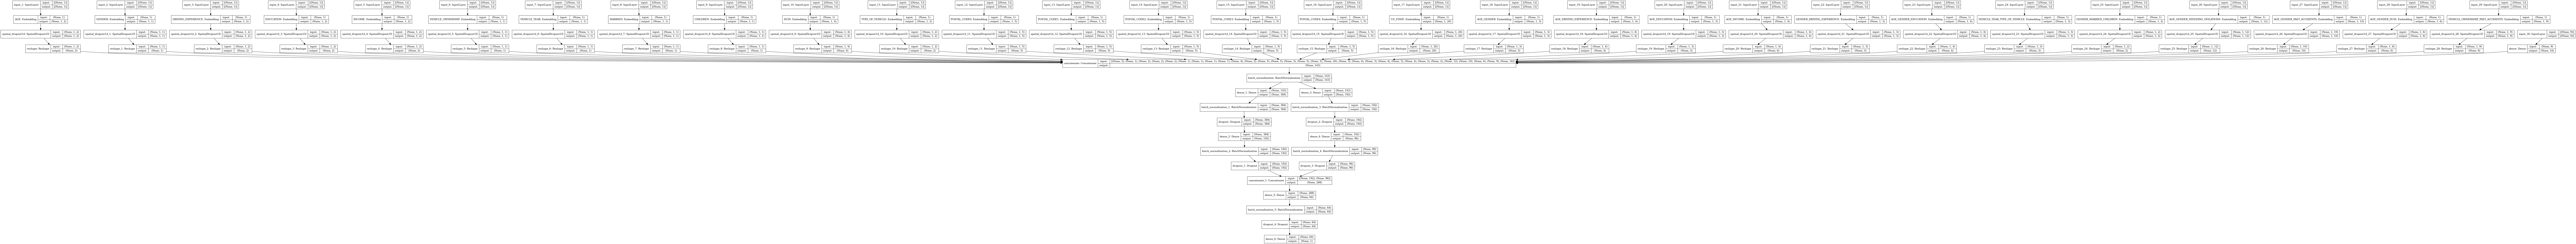

In [17]:
tf.keras.utils.plot_model(
    model, to_file='./Analytics_Olympiad_Model.png', 
    show_shapes=True, show_layer_names=True
)

In [18]:
FOLD = 25
SEEDS = [42]
VERBOSE = 0
BATCH_SIZE = 256

results = {}
counter = 0
oof_score = 0
y_pred_meta_dnn = np.zeros((train.shape[0], 1))
y_pred_final_dnn = np.zeros((test.shape[0], 1))


for sidx, seed in enumerate(SEEDS):
    seed_score = 0
    
    kfold = StratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)

    for idx, (train_idx, val_idx) in enumerate(kfold.split(train[features], train['OUTCOME'])):
        counter += 1

        train_x, train_y = train[features].iloc[train_idx], train['OUTCOME'].iloc[train_idx]
        val_x, val_y = train[features].iloc[val_idx], train['OUTCOME'].iloc[val_idx]

        model = neural_nets(cat_cols, num_cols)
        model.compile(
            loss='binary_crossentropy', 
            optimizer=optimizers.Adam(learning_rate=1e-2)
        )

        early = callbacks.EarlyStopping(
            monitor="val_loss", 
            mode="min", 
            restore_best_weights=True, 
            patience=10, 
            verbose=VERBOSE
        )

        reduce_lr = callbacks.ReduceLROnPlateau(
            monitor="val_loss", 
            factor=0.5, 
            min_lr=1e-5, 
            patience=3, 
            verbose=VERBOSE, 
            mode='min'
        )

        chk_point = callbacks.ModelCheckpoint(
            f'./Analytics_Olympiad_Model_{counter}C.h5', 
            monitor='val_loss', 
            verbose=VERBOSE, 
            save_best_only=True, 
            mode='min'
        )

        history = model.fit(
            [[train_x[col] for col in cat_cols], train_x[num_cols]], 
            train_y, 
            batch_size=BATCH_SIZE,
            epochs=100, 
            verbose=VERBOSE, 
            callbacks=[reduce_lr, early, chk_point], 
            validation_data=([[val_x[col] for col in cat_cols], val_x[num_cols]], val_y)
        )

        model = models.load_model(f'./Analytics_Olympiad_Model_{counter}C.h5')

        y_pred = model.predict([[val_x[col] for col in cat_cols], val_x[num_cols]], 
                               batch_size=BATCH_SIZE, verbose=VERBOSE)
        y_pred_meta_dnn[val_idx] += y_pred
        y_pred_final_dnn += model.predict([[test[col] for col in cat_cols], test[num_cols]], 
                                          batch_size=BATCH_SIZE, verbose=VERBOSE)
        
        score = log_loss(val_y, y_pred)
        oof_score += score
        seed_score += score
        print(f"Seed-{seed} | Fold-{idx+1} | OOF Score: {score}")
        
        if 'BASELINE' in results.keys():
            results['BASELINE'] = results['BASELINE'] + (score/float(FOLD))
        else:
            results['BASELINE'] = score/float(FOLD)
        
        for col in tqdm(features):
            new_df = val_x.copy()
            tmp = new_df[col].values
            np.random.shuffle(tmp)
            new_df[col] = tmp

            y_pred = model.predict([[new_df[col] for col in cat_cols], new_df[num_cols]], 
                                   batch_size=BATCH_SIZE, verbose=VERBOSE)
            loss = log_loss(val_y, y_pred)

            if col in results.keys():
                results[col] = results[col] + (loss/float(FOLD))
            else:
                results[col] = loss/float(FOLD)
        
        del model, y_pred
        del train_x, train_y
        del val_x, val_y, new_df
        gc.collect()
    
    print(f"\nSeed: {seed} | Aggregate OOF Score: {seed_score / FOLD}\n\n")


y_pred_meta_dnn = y_pred_meta_dnn / float(len(SEEDS))
y_pred_final_dnn = y_pred_final_dnn / float(counter)
oof_score /= float(counter)
print("Aggregate OOF Score: {}".format(oof_score))

2022-10-25 04:34:55.099943: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Seed-42 | Fold-1 | OOF Score: 0.6811116574066026


100%|██████████| 38/38 [00:12<00:00,  2.94it/s]


Seed-42 | Fold-2 | OOF Score: 0.68107414757212


100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


Seed-42 | Fold-3 | OOF Score: 0.6813021887767883


100%|██████████| 38/38 [00:13<00:00,  2.87it/s]


Seed-42 | Fold-4 | OOF Score: 0.681392704702559


100%|██████████| 38/38 [00:13<00:00,  2.76it/s]


Seed-42 | Fold-5 | OOF Score: 0.6811034401399748


100%|██████████| 38/38 [00:13<00:00,  2.88it/s]


Seed-42 | Fold-6 | OOF Score: 0.6809286586088794


100%|██████████| 38/38 [00:13<00:00,  2.90it/s]


Seed-42 | Fold-7 | OOF Score: 0.6810325819253922


100%|██████████| 38/38 [00:13<00:00,  2.76it/s]


Seed-42 | Fold-8 | OOF Score: 0.6801732270348639


100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


Seed-42 | Fold-9 | OOF Score: 0.6809496696719102


100%|██████████| 38/38 [00:12<00:00,  2.94it/s]


Seed-42 | Fold-10 | OOF Score: 0.6814257181755135


100%|██████████| 38/38 [00:13<00:00,  2.83it/s]


Seed-42 | Fold-11 | OOF Score: 0.6807380350785596


100%|██████████| 38/38 [00:13<00:00,  2.90it/s]


Seed-42 | Fold-12 | OOF Score: 0.6813673220645814


100%|██████████| 38/38 [00:14<00:00,  2.68it/s]


Seed-42 | Fold-13 | OOF Score: 0.680821352033388


100%|██████████| 38/38 [00:12<00:00,  3.01it/s]


Seed-42 | Fold-14 | OOF Score: 0.6810660122831662


100%|██████████| 38/38 [00:12<00:00,  2.93it/s]


Seed-42 | Fold-15 | OOF Score: 0.68090206031998


100%|██████████| 38/38 [00:13<00:00,  2.88it/s]


Seed-42 | Fold-16 | OOF Score: 0.6806429271967638


100%|██████████| 38/38 [00:13<00:00,  2.91it/s]


Seed-42 | Fold-17 | OOF Score: 0.6804401441557066


100%|██████████| 38/38 [00:12<00:00,  3.00it/s]


Seed-42 | Fold-18 | OOF Score: 0.6809452759722868


100%|██████████| 38/38 [00:12<00:00,  2.99it/s]


Seed-42 | Fold-19 | OOF Score: 0.6809212008544377


100%|██████████| 38/38 [00:12<00:00,  2.98it/s]


Seed-42 | Fold-20 | OOF Score: 0.6808406176595461


100%|██████████| 38/38 [00:12<00:00,  2.96it/s]


Seed-42 | Fold-21 | OOF Score: 0.6813836981710933


100%|██████████| 38/38 [00:13<00:00,  2.89it/s]


Seed-42 | Fold-22 | OOF Score: 0.6805710871943406


100%|██████████| 38/38 [00:13<00:00,  2.78it/s]


Seed-42 | Fold-23 | OOF Score: 0.6803404433883372


100%|██████████| 38/38 [00:12<00:00,  3.06it/s]


Seed-42 | Fold-24 | OOF Score: 0.6810767946569692


100%|██████████| 38/38 [00:12<00:00,  2.92it/s]


Seed-42 | Fold-25 | OOF Score: 0.6808541105119955


100%|██████████| 38/38 [00:13<00:00,  2.79it/s]



Seed: 42 | Aggregate OOF Score: 0.6809362030222301


Aggregate OOF Score: 0.6809362030222301


## Review model performance

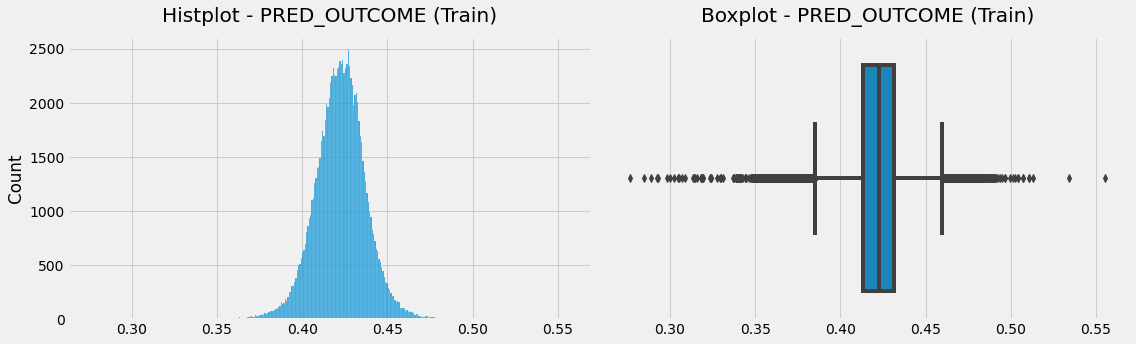

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(x=y_pred_meta_dnn.ravel(), ax=ax[0])
sns.boxplot(x=y_pred_meta_dnn.ravel(), ax=ax[1])
ax[0].set_title(f"Histplot - PRED_OUTCOME (Train)", pad=15)
ax[1].set_title(f"Boxplot - PRED_OUTCOME (Train)", pad=15)
fig.tight_layout();

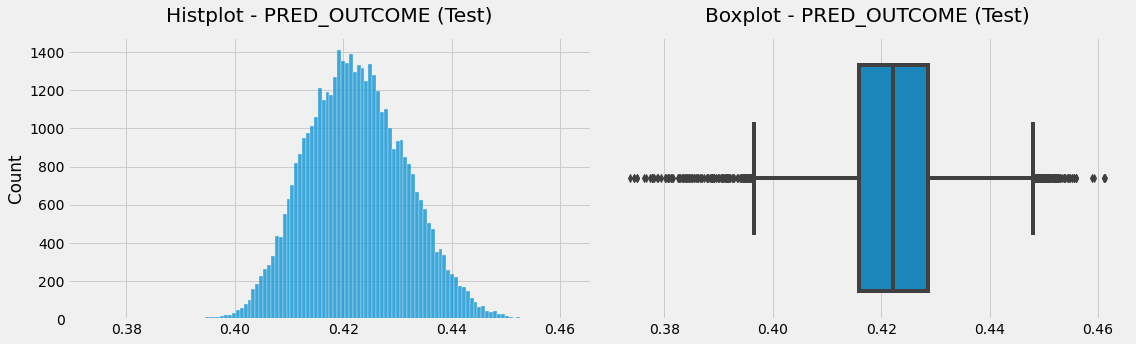

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.histplot(x=y_pred_final_dnn.ravel(), ax=ax[0])
sns.boxplot(x=y_pred_final_dnn.ravel(), ax=ax[1])
ax[0].set_title(f"Histplot - PRED_OUTCOME (Test)", pad=15)
ax[1].set_title(f"Boxplot - PRED_OUTCOME (Test)", pad=15)
fig.tight_layout();

In [21]:
df = pd.DataFrame(results.items(), columns=['feature','logloss'])
df = df.sort_values('logloss')
df.head()

,feature,logloss
19,POSTAL_CODE1,0.680923
34,SPEEDING_VIOLATIONS+DUIS+PAST_ACCIDENTS,0.680924
2,AGE,0.680929
6,INCOME,0.680929
23,AGE+GENDER,0.680929


In [22]:
baseline_loss = results['BASELINE']
baseline_loss

0.6809362030222299

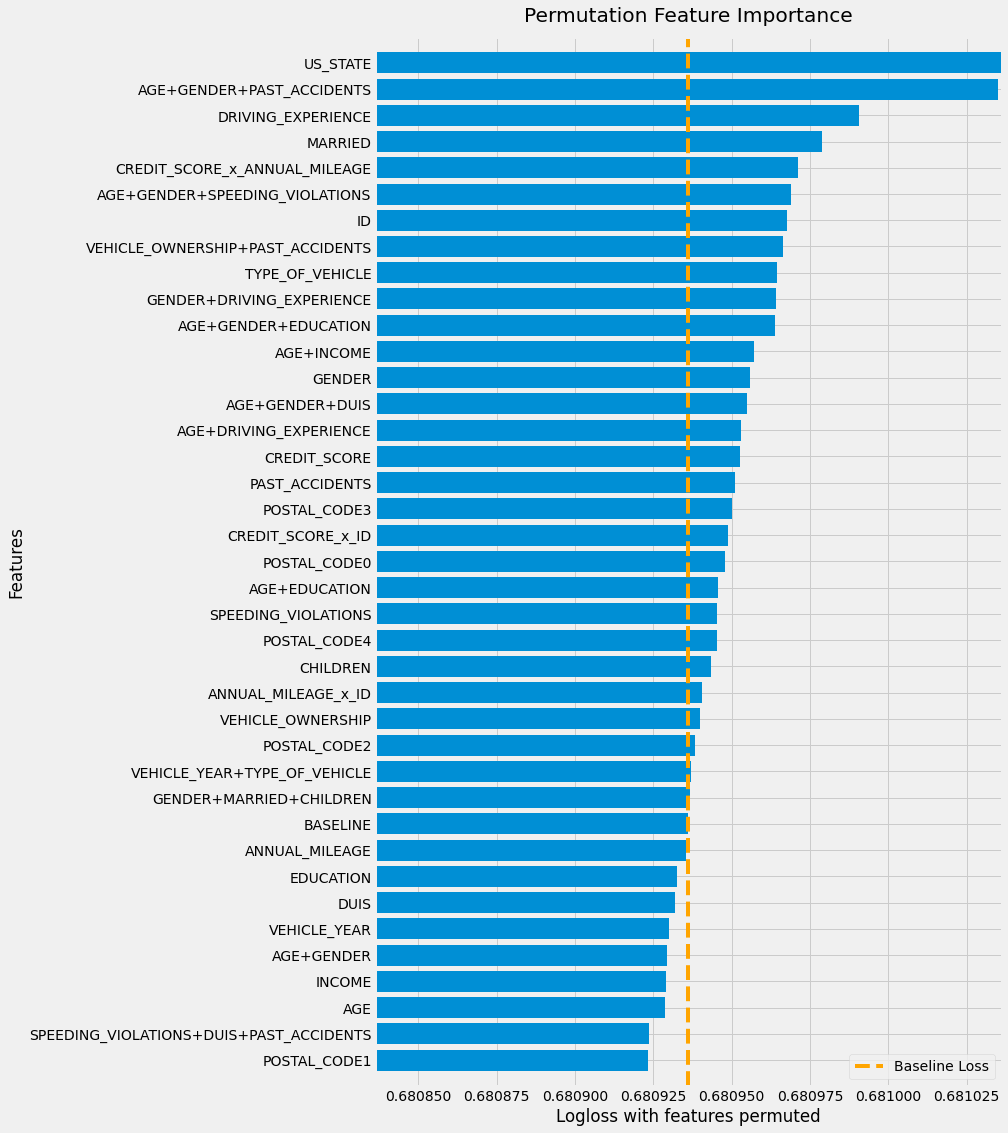

In [23]:
plt.figure(figsize=(10, 18))
plt.barh(np.arange(len(features)+1), df.logloss)
plt.yticks(np.arange(len(features)+1), df.feature.values)
plt.xlim((baseline_loss-0.0001, baseline_loss+0.0001))
plt.ylim((-1, len(features)+1))
plt.plot([baseline_loss, baseline_loss], [-1, len(features)+1], 
         '--', color='orange', label='Baseline Loss')
plt.title('Permutation Feature Importance', pad=15)
plt.xlabel(f'Logloss with features permuted')
plt.ylabel('Features')
plt.legend();

## Create submission file

In [24]:
sub = pd.read_csv("../input/mh-analytics-olympiad-2022/AnalyticsOlympiad2022Data/submission.csv")
sub['OUTCOME'] = y_pred_final_dnn.ravel()
sub.to_csv("./new_dawn_sub_v9.csv", index=False)
sub.head()

,OUTCOME
0,0.420051
1,0.442620
2,0.409475
3,0.410755
4,0.394818


In [25]:
## Good Day!!